In [2]:
%load_ext autoreload
%autoreload 2


In [6]:
import sys
sys.path.append('../../')

from pprint import pprint
import numpy as np
import descarteslabs as dl

from src.ReMasFrame import *

nasa_df = ReMasFrame()

# Choose an idx --> a landslide (or filter the geodataframe :D)
idx_test = 11031

# changes Point to Polygon
# nasa_df_polygon = nasa_df.create_box(8000000)

# Returns products that we use as a dict
products = nasa_df.get_products()

nasa_df.loc[idx_test, :]

location_description        Ayu, Ozgon, Osh, Kyrgyzstan
landslide_size                                    large
event_date                                   2017-04-29
landslide_category                  translational_slide
landslide_trigger                              downpour
fatality_count                                       24
injury_count                                        NaN
longitude                                       73.4724
latitude                                        40.8864
geometry                POINT (73.47237853 40.88639497)
Name: 11031, dtype: object

In [7]:
pprint(products['population'])

{'bands': ['population'],
 'id': 'd15c019579fa0985f7006094bba7c7288f830e1f:GPW_Population_Density_V4_0',
 'res': '1km'}


In [50]:
def get_population(product, res=0.01, buffer_size=0.1):
    
    scenes, ctx = ReMasFrame.search_scenes(
        nasa_df['geometry'][idx_test].buffer(buffer_size).envelope, 
        product['id'], 
        start_date="2000-01-01"
    )
    
    # get closest date to event
    from datetime import timedelta
    
    e_date = parse(nasa_df.event_date[idx_test])
    
    min_dist_idx = [timedelta(days=10e6), -1]
    
    for idx, scene in enumerate(scenes):
        dist = abs(scene.properties.date - e_date)
        if  dist < min_dist_idx[0]:
            min_dist_idx = [dist, idx]
    
    new_ctx = ctx.assign(resolution=res)
    
    return (scenes[min_dist_idx[1]], new_ctx)

In [55]:
(scene, ctx) = get_population(products['population'])

array = scene.ndarray("population", ctx)

scene

Scene "d15c019579fa0985f7006094bba7c7288f830e1f:GPW_Population_Density_V4_0:gpw_v4_population_density_rev11_2015_30_sec"
  * Product: "d15c019579fa0985f7006094bba7c7288f830e1f:GPW_Population_Density_V4_0"
  * CRS: "+proj=longlat +datum=WGS84 +no_defs "
  * Date: Thu Jan  1 00:00:00 2015
  * Bands:
    * population: Float32, [0.0, 2000000.0]

In [58]:
array.shape, array.mean()

((1, 21, 21), 76.49674036281179)

In [62]:
scene_stack = array.reshape((1,1,array.shape[1], array.shape[2])) 
scene_stack.shape

(1, 1, 21, 21)

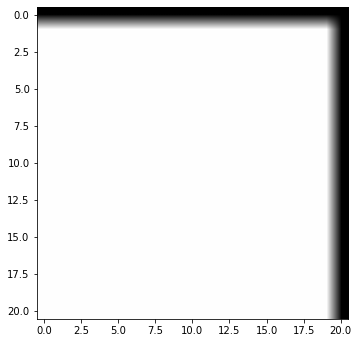

In [59]:
dl.scenes.display(array, size=5)